## Data Analytics final project <br>
Authors: Piotr Pawełczak, Mateusz Pilecki

## Project formulation <br>

The goal of our project is to calculate rent price of flat in Warsaw based on area. <br>
To achieve this goal, we decided to use Bayesian inference to generate distribution of prices. <br>
Both models used in this project have to return price distribution based on selected priors, collected data and parameters of model.

<br><br>
Final version on model can be used to give information about price to potential user. <br>
<br> Use case: <br><br>
Trigger: User want to get information about price by given area <br><br>
Scenario: 
- User enter area of flat <br>
- Model calculate marginal distribution for selected input <br>
- User get information about distribution of price according to selected area in input

## Models
<br> We created 2 models. First one based on normal distribution, second one based on student t distribution. <br>
Models are more detailed described in chapters dedicated to that models.

<br>
In difference to normal distribution, student t introduces parameter nu - degrees of freedom. <br>
Degrees of freedom can improve model when there are outliers in data or there is small amount of data (in our case, we use 300 samples). <br>

Input data for both models are:
<br> Area of flat in m^2 [int] - predictor 
<br> Price of rent [int] -  value that we want to predict 
<br> N [int] - number of samples 

## Data import and preprocessing

Dataset comes from https://www.kaggle.com/datasets/beksultankarimov/warsaw-flat-rent-prices. <br>
In the link there is data collected by person, who lives in Warsaw and wanted to rent a flat. <br>
Source of the data is page www.otodom.pl

In [140]:
# Import libraries to handle data
import pandas as pd
import arviz as az
from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
from DA_tools.DA_colors import *
from DA_tools.DA_tools import ribbon_plot

In [141]:
# Load and visualizate data
raw_data = pd.read_csv('otodom_complete.csv')
raw_data.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'offer_url',
       'offer_url-href', 'location', 'net_price', 'deposit', 'area',
       'room_num', 'build_type', 'floor', 'total_floor', 'build_mat',
       'windows', 'heating', 'year_built', 'status', 'agd', 'security',
       'add_info', 'rest_info', 'offer_ID', 'next_pagination',
       'next_pagination-href', 'add_cost', 'offer_last_update', 'second_page',
       'second_page-href', 'third_page', 'third_page-href'],
      dtype='object')

In [142]:
raw_data.head()

,web-scraper-order,web-scraper-start-url,offer_url,offer_url-href,location,net_price,deposit,area,room_num,build_type,...,rest_info,offer_ID,next_pagination,next_pagination-href,add_cost,offer_last_update,second_page,second_page-href,third_page,third_page-href
0,1612265907-2487,https://www.otodom.pl/wynajem/mieszkanie/warsz...,37 m²\n \n ...,https://www.otodom.pl/pl/oferta/wynajme-od-zar...,"Warszawa, Włochy, ul. 1 Sierpnia",2 100 zł,Kaucja:2 100 zł,Powierzchnia:37 m²,Liczba pokoi:2,NaN,...,klimatyzacja,Nr oferty w Otodom: 61451923,NaN,https://www.otodom.pl/wynajem/mieszkanie/warsz...,NaN,Data aktualizacji: 3 dni temu,NaN,NaN,NaN,NaN
1,1612264314-1965,https://www.otodom.pl/wynajem/mieszkanie/warsz...,38 m²\n \n ...,https://www.otodom.pl/pl/oferta/2-pokoje-tanio...,"Warszawa, Mokotów, ul. Suwak 11",1 825 zł,Kaucja:3 400 zł,Powierzchnia:38 m²,Liczba pokoi:2,Rodzaj zabudowy:blok,...,garaż/miejsce parkingowewindapom. użytkowe,Nr oferty w Otodom: 61405987,NaN,https://www.otodom.pl/wynajem/mieszkanie/warsz...,Czynsz - dodatkowo:350 zł,Data aktualizacji: 2 dni temu,NaN,NaN,NaN,NaN
2,1612263242-1616,https://www.otodom.pl/wynajem/mieszkanie/warsz...,57 m²\n \n ...,https://www.otodom.pl/pl/oferta/wynajme-mieszk...,"Warszawa, Bielany, ul. Kwitnąca",3 300 zł,Kaucja:3 300 zł,Powierzchnia:57 m²,Liczba pokoi:3,Rodzaj zabudowy:blok,...,balkontylko dla niepalącychoddzielna kuchnia,Nr oferty w Otodom: 61375474,NaN,https://www.otodom.pl/wynajem/mieszkanie/warsz...,Czynsz - dodatkowo:1 zł,Data aktualizacji: 22 dni temu,NaN,NaN,NaN,NaN
3,1612265477-2346,https://www.otodom.pl/wynajem/mieszkanie/warsz...,63 m²\n \n ...,https://www.otodom.pl/pl/oferta/zielone-zacisz...,"Warszawa, Targówek, ul. św. Wincentego",2 200 zł,NaN,Powierzchnia:63 m²,Liczba pokoi:2,Rodzaj zabudowy:blok,...,NaN,Nr oferty w Otodom: 61439492,NaN,https://www.otodom.pl/wynajem/mieszkanie/warsz...,NaN,Data aktualizacji: 5 dni temu,NaN,NaN,NaN,NaN
4,1612266187-2579,https://www.otodom.pl/wynajem/mieszkanie/warsz...,65 m²\n \n ...,https://www.otodom.pl/pl/oferta/eleganckie-mie...,"Warszawa, Ochota, Stara Ochota, ul. Juliana Ur...",3 000 zł,Kaucja:3 000 zł,Powierzchnia:65 m²,Liczba pokoi:3,Rodzaj zabudowy:kamienica,...,NaN,Nr oferty w Otodom: 61455072,NaN,NaN,NaN,Data aktualizacji: 2 dni temu,NaN,NaN,NaN,NaN


Dataset contains various parameters such as offert_url, location, price netto, deposit, area, <br>
aditional features of flat (such as air conditioning, alarm system, type of building).

#### Preprocessing

In our case we want to find relation between area of flat and price. Area can be selected from column 'offer_url'. <br>
Informations about price are located in columns 'net_price' and 'add_cost'.

In [143]:
# Selecting important columns
clipped_data = raw_data[['offer_url', 'net_price', 'add_cost']]
clipped_data.head()

,offer_url,net_price,add_cost
0,37 m²\n \n ...,2 100 zł,NaN
1,38 m²\n \n ...,1 825 zł,Czynsz - dodatkowo:350 zł
2,57 m²\n \n ...,3 300 zł,Czynsz - dodatkowo:1 zł
3,63 m²\n \n ...,2 200 zł,NaN
4,65 m²\n \n ...,3 000 zł,NaN


In [144]:
# Extract area of flat
data = pd.DataFrame()
selected_area = clipped_data['offer_url'].str.split(' m', expand=True)[0]

# Convert to numeric format 
selected_area = selected_area.str.replace(',', '.').astype(float)
data['area'] = selected_area

In [145]:
# Select net_price
net_price = clipped_data['net_price'].str[:-3] # Remove currency info (PLN)
net_price = net_price.str.replace(' ', '') # Remove white spaces
net_price = net_price.str.replace(',', '.').astype(float) # Convert to float type
data['net_price'] = net_price

# Select additional cosst
add_cost = clipped_data['add_cost'].str.split(':', expand=True)[1] # Select part with cost info
add_cost = add_cost.str[:-3] # Remove currency info (PLN)
add_cost = add_cost.str.replace(' ', '') # Remove white spaces
add_cost = add_cost.str.replace(',', '.').astype(float) # Convert to float type

data['add_cost'] = add_cost


In result we get data with following structure

In [146]:
data.head()

,area,net_price,add_cost
0,37.0,2100.0,NaN
1,38.0,1825.0,350.0
2,57.0,3300.0,1.0
3,63.0,2200.0,NaN
4,65.0,3000.0,NaN


Information about data

In [147]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3482 entries, 0 to 3481
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   area       3482 non-null   float64
 1   net_price  3481 non-null   float64
 2   add_cost   1915 non-null   float64
dtypes: float64(3)
memory usage: 81.7 KB


To clean data, rows with NaN in net_price will be deleted and NaN in add_cost will be replaced with 0

In [148]:
data = data[pd.notnull(data['net_price'])]
data['add_cost'] = data['add_cost'].fillna(0)

In [149]:
# Convert data to integers
data['area'] = data['area'].astype(int)
data['net_price'] = data['net_price'].astype(int)
data['add_cost'] = data['add_cost'].astype(int)

# Calculate total price
data['total_price'] = data['net_price'] + data['add_cost']

# Save data to csv
data.to_csv('cleaned_data.csv')

In [150]:
# Filter data to reasonable values
data = data[data['area'] <= 100]
data = data[data['total_price'] <= 7500]


In [151]:
data.head()

,area,net_price,add_cost,total_price
0,37,2100,0,2100
1,38,1825,350,2175
2,57,3300,1,3301
3,63,2200,0,2200
4,65,3000,0,3000


# Priors

We selected priors based on data we got from otodom: <br>
https://www.otodom.pl/pl/oferty/wynajem/mieszkanie/warszawa?by=PRICE&direction=ASC&page=1 <br>
After anylysis of Warsaw rental announcements we decided to sset following parameters for prior.

Parameters for prior were selected in the following way: <br>
Mean value was selected to 3500, and standard deviation was selected 500, which gives us following distribution: <br>
- 68% of generated data are in range [3000, 4000] <br>
- 95% of generated data are in range [2500, 4500] <br>
- 99% of generated data are in range [2000, 5000] <br>

In our opinion, that distribution of mean value is sensible.


<br>
Parameter beta was sampled from longnormal distribution, because in general, the bigger area is, the higher is price, so slope should be positive. Lognormal distribution can ensure that sampled value is positive. <br>
Distribution Beta(3, 1) was selected to make sure, that slope will affect relation between price and area, as value of price is much bigger than value of area). Slope should have value of few decades to give reasonable relativity. Not to high, but observable.  <br>

<br>
Standard deviation of normal distribution of price was selected by exponential distribution Exp(0.005), which give us 200PLN deviation of price.

In our model, we decided to use predictor: area. It is good for model to do centering of predictor (substract mean value from every record). <br>
This operation gives interpretability for the coeffcient. For mean value of area, there will be predicted mean value of price (for mean value of area, c_area is 0).

In [152]:
data['c_area'] = data.area - data.area.mean()

In [153]:
data.head()

,area,net_price,add_cost,total_price,c_area
0,37,2100,0,2100,-7.3566
1,38,1825,350,2175,-6.3566
2,57,3300,1,3301,12.6434
3,63,2200,0,2200,18.6434
4,65,3000,0,3000,20.6434


For simulation data, we created vector of equally spaced values of c_area in range [min(c_area), max(c_area)]

In [154]:
N = 50
area = np.linspace(data.c_area.min(), data.c_area.max(), N)
data_sim = {'N': N, 'area': area}

### Prior predictive check [Model 1 - Normal]

In [155]:
normal_model_ppc = CmdStanModel(stan_file='normal_ppc.stan')

R = 1000
sim_normal = normal_model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=1)

alpha_sim_normal = sim_normal.stan_variable('alpha')
beta_sim_normal = sim_normal.stan_variable('beta')
price_sim_normal = sim_normal.stan_variable('price')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


### Simulated parameters

Histograms of simulated aplha and beta

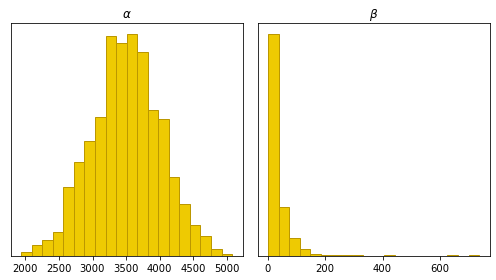

In [156]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

ax = axes[0]
ax.hist(alpha_sim_normal, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT, density=True)
ax.set_title(r'$\alpha$')
ax.set_yticks(())

ax2 = axes[1]
ax2.hist(beta_sim_normal, bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax2.set_title(r'$\beta$')
ax2.set_yticks(())
fig.tight_layout()

plt.show()

Aplha has mean value in 3500. Beta has most of time slightly slope. There are some hilly slopes, but in general, there are in reasonable range. Choosen priors give values, that have sense

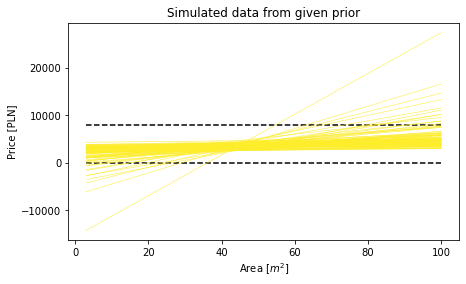

In [157]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines([0,8000],xmin=data.area.min(),xmax=data.area.max(),linestyle='--',color='black')
for i in range(100):
    axes.plot(data.area,alpha_sim_normal[i] + beta_sim_normal[i] * data.c_area, color=MID, alpha=0.5, linewidth=0.5)
axes.set_xlabel('Area [$m^2$]')
axes.set_ylabel('Price [PLN]')
axes.set_title(r'Simulated data from given prior')
plt.show()

Simulated data is mostly in range [0, 10000]. There are singluar lines that gives irrational values, but generally, data is sampled sensibly.

### Simulated measurements

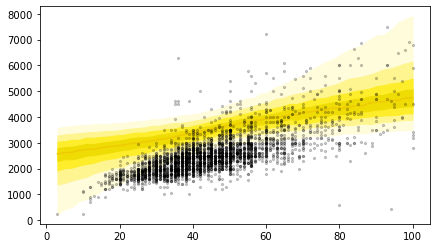

In [158]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes = ribbon_plot(data_sim['area'] + data.area.mean(), price_sim_normal, axes)
axes.scatter(data.area, data.total_price, color='black', alpha=0.2,s=5)
plt.show()


Observed data matches area of interested generated from models. Based on graphs, we assume, that priors have been selected correctly.

# Model 1: Normal Distribution

We assume, that price distribution can be described as normal distribution. Our model based on normal distribution has following formulas: <br>

$price_i$ ~ Normal $(\mu_i, \sigma)$ <br>
$\mu_i = \alpha + \beta * area_i$ <br>
$\alpha$ ~ Normal(3500, 500) <br>
$\beta$ ~ Logormal(3, 1) <br>
$\sigma$ ~ Exponential(0.005) <br>

## Posterior

In [159]:
DATA_SIZE = 300

In [160]:
model_fit_normal = CmdStanModel(stan_file="normal_fit.stan")

INFO:cmdstanpy:found newer exe file, not recompiling


In [161]:
d_short=data.head(DATA_SIZE)

data_fit = {
    "N": len(d_short),
    "area": d_short.c_area.values,
    "price": d_short.total_price.values
}

fit_normal = model_fit_normal.sample(data=data_fit, seed=1, chains=1)
alpha_fit_normal = fit_normal.stan_variable('alpha')
beta_fit_normal = fit_normal.stan_variable('beta')
mu_fit_normal = fit_normal.stan_variable('mu')
price_pred_normal = fit_normal.stan_variable('price_pred')

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [162]:
# Diagnose fit
fit_normal.diagnose()

'Processing csv files: C:\\Users\\piotr\\AppData\\Local\\Temp\\tmpvdux1lel\\normal_fit-20220621112722.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

According to diagnose result, there were no problems with sampling. Model is well defined.

In [163]:
az.summary(fit_normal, var_names=['alpha', 'beta', 'sigma'], kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
alpha,2523.73,29.83,2466.62,2576.11
beta,38.37,1.99,34.55,42.03
sigma,535.27,21.72,492.88,573.54


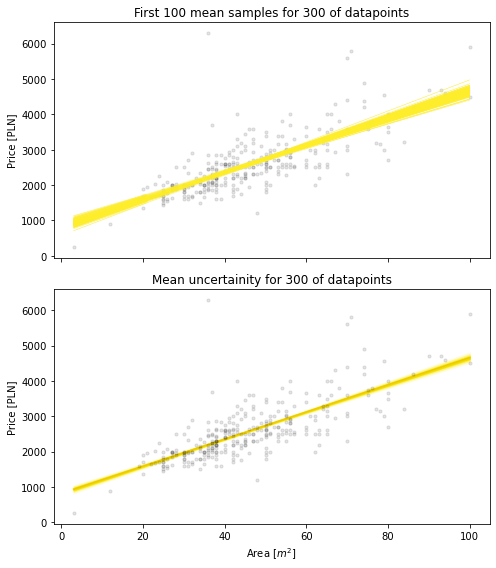

In [164]:
fig, axes = plt.subplots(2,1, figsize=(7, 8),sharey=True,sharex=True)
ax0=axes[0]

NUM_OF_SAMPLES = 100
for i in range(NUM_OF_SAMPLES):
    ax0.plot(d_short.area,
              alpha_fit_normal[i] + beta_fit_normal[i] * d_short.c_area,
              color=MID,
              alpha=0.5,linewidth=0.5)

ax0.scatter(d_short.area,d_short.total_price,color='black',alpha=0.1,s=10)
ax0.set_ylabel('Price [PLN]')
ax0.set_title('First {} mean samples for {} of datapoints'.format(NUM_OF_SAMPLES, len(d_short)))

ax1=axes[1]
ax1=ribbon_plot(d_short.area.values, mu_fit_normal, ax1, supress_warning=True)
ax1.scatter(d_short.area, d_short.total_price, color='black', alpha=0.1, s=10)
ax1.set_xlabel('Area [$m^2$]')
ax1.set_ylabel('Price [PLN]')

ax1.set_title('Mean uncertainity for {} of datapoints'.format(len(d_short)))
fig.tight_layout()
plt.show()

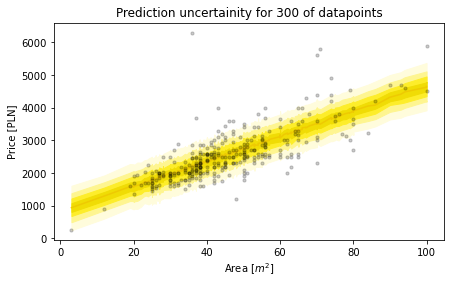

In [165]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))

axes = ribbon_plot(d_short.area.values, price_pred_normal, axes,supress_warning=True)
axes.scatter(d_short.area, d_short.total_price,color='black',alpha=0.2,s=10)
axes.set_xlabel('Area [$m^2$]')
axes.set_ylabel('Price [PLN]')
axes.set_title('Prediction uncertainity for {} of datapoints'.format(len(d_short)))
plt.show()

Posterior predictive samples are consistent with observed data. Most of data are in area of interest generated from model. <br>
We can see strongly linear correlation. Thera are also some outliers in observed data. For example price 6000 for area 40. <br>
In our case they are rearely enough. Even that, there are outliers, model generated consistent data

Most of observed data are in range of area [30, 50] and price [1000, 3000]. <br>
In plot above, we can see that parameter for slope is sampled almost perfectly, and sampled mean value avarege value of observed data.

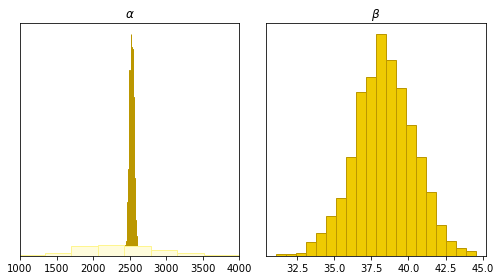

In [166]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

ax = axes[0]
ax.hist(alpha_fit_normal, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT, density=True)
ax.hist(data.total_price, bins=20,color=LIGHT,edgecolor=LIGHT_HIGHLIGHT,density=True)
ax.set_title(r'$\alpha$')
ax.set_yticks(())
ax.set_xlim(1000, 4000)

ax2 = axes[1]
ax2.hist(beta_fit_normal, bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax2.set_title(r'$\beta$')
ax2.set_yticks(())
fig.tight_layout()
plt.show()

Sampled parameters are cenetered. Sampled alpha has mean value in 2500 and have low standard deviation. <br>
Beta have normal distribution with mean value in 38. <br> 

In plot of alpha is wider range of axis x, than in plot of beta, however parameter beta is also centered. <br>
There is huge improvement of parameters distribution in posterior than in prior predicitve check. <br>
Parameter of beta generally have range that we wanted to achieve by setting prior parameters.

## Marginal for selected area

Generate distribution of price for given area

In [167]:
def plot_marginal(area: int, type="normal"):

    if type == "normal":
        marginal_mu = alpha_fit_normal + beta_fit_normal * (area - data.area.mean())
    elif type == "student":
        marginal_mu = alpha_fit_student + beta_fit_student * (area - data.area.mean())

    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    ax.hist(marginal_mu, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT, density=True)
    ax.set_title(f'Mean for area {area}$m^2$')
    ax.set_yticks(())
    ax.set_xlabel(f'mu|area={area} $m^2$')
    plt.show()

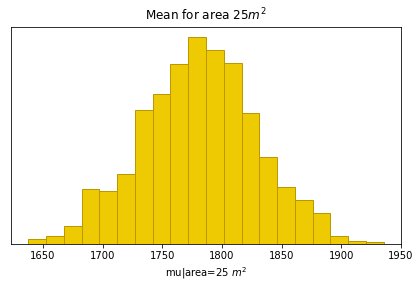

In [168]:
plot_marginal(25)


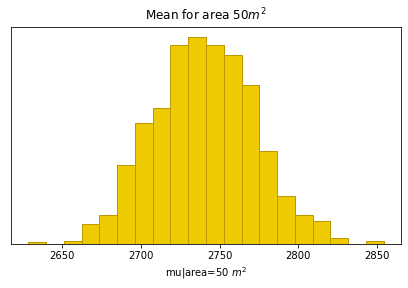

In [169]:
plot_marginal(50)


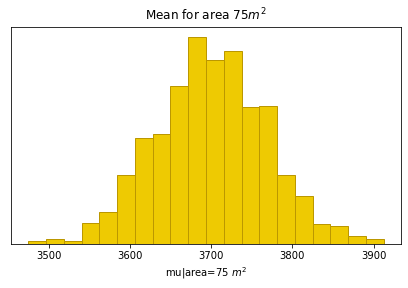

In [170]:
plot_marginal(75)


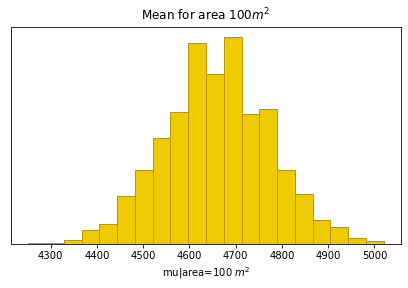

In [171]:
plot_marginal(100)


Distribution seems to be correct. The bigger area is, the higher is estimated price.

## Prior predicitve check [Model 2 - Student T]

In [172]:
student_model_ppc = CmdStanModel(stan_file='student_ppc.stan')

R = 1000
sim_student = student_model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=1)

alpha_sim_student = sim_student.stan_variable('alpha')
beta_sim_student = sim_student.stan_variable('beta')
price_sim_student = sim_student.stan_variable('price')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


### Simulated parameters

Histogram of simulated aplha and beta

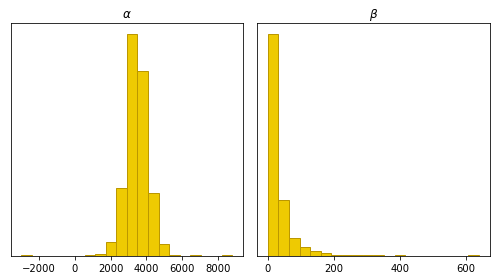

In [173]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

ax = axes[0]
ax.hist(alpha_sim_student, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT, density=True)
ax.set_title(r'$\alpha$')
ax.set_yticks(())

ax2 = axes[1]
ax2.hist(beta_sim_student, bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax2.set_title(r'$\beta$')
ax2.set_yticks(())
fig.tight_layout()

plt.show()

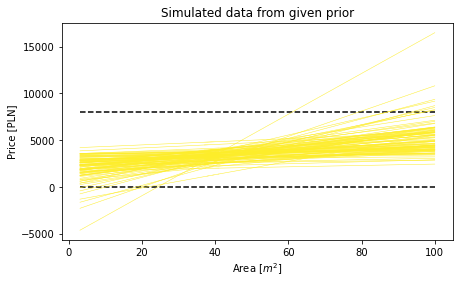

In [174]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines([0,8000],xmin=data.area.min(),xmax=data.area.max(),linestyle='--',color='black')
for i in range(100):
    axes.plot(data.area,alpha_sim_student[i] + beta_sim_student[i] * data.c_area, color=MID, alpha=0.5, linewidth=0.5)
axes.set_xlabel('Area [$m^2$]')
axes.set_ylabel('Price [PLN]')
axes.set_title(r'Simulated data from given prior')
plt.show()

Simulated data is mostly in range [0, 10000]. There are singluar lines that gives irrational values, but generally, data is sampled sensibly. Simulated data is slightly better than in previous model. Less lines are out of boundary [0, 10000].

### Simulated measurements

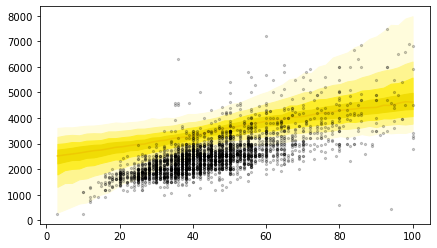

In [175]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes = ribbon_plot(data_sim['area'] + data.area.mean(), price_sim_student, axes)
axes.scatter(data.area, data.total_price, color='black', alpha=0.2,s=5)
plt.show()

Observed data matches area of interested generated from models. Based on graphs, we assume, that priors have been selected correctly.

# Model 2: Student T Distribution

-are models sufficiently described (what are formulas, what are parameters, what data are required ) [1 pt]<br>

Since normal distribution is very sensitive for outliers we decided to create new model with student-T distribution to see if we can increase performance. Our information about priors are informative, but there where some outliers that could be problematic for normal distribution model. 

To formulate model we chose <br>

$price_i$ ~ Student_t $(\nu, \mu_i, \sigma)$ <br>
$\nu$ ~ Gamma(2, 0.1) <br>
$\mu_i = \alpha + \beta * area_i$ <br>
$\alpha$ ~ Student_t($\nu_i$, 3500, 500) <br>
$\beta$ ~ Logormal(3, 1) <br>
$\sigma$ ~ Exponential(0.005) <br>

## Posterior

In [176]:
model_fit_student = CmdStanModel(stan_file="student_fit.stan")

INFO:cmdstanpy:found newer exe file, not recompiling


In [177]:
d_short=data.head(DATA_SIZE)

data_fit = {
    "N": len(d_short),
    "area": d_short.c_area.values,
    "price": d_short.total_price.values
}

fit_student = model_fit_student.sample(data=data_fit,seed=1, chains=1)
alpha_fit_student = fit_student.stan_variable('alpha')
beta_fit_student = fit_student.stan_variable('beta')
mu_fit_student = fit_student.stan_variable('mu')
nu_fit_student = fit_student.stan_variable('nu')
price_pred_student = fit_student.stan_variable('price_pred')

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:02 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [178]:
# Fit diagnose
fit_student.diagnose()

'Processing csv files: C:\\Users\\piotr\\AppData\\Local\\Temp\\tmpvdux1lel\\student_fit-20220621112742.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

According to diagnose result, there were no problems with sampling. Model is well defined.

In [179]:
az.summary(fit_student, var_names=['alpha', 'beta', 'sigma', 'nu'], kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
alpha,2471.22,23.74,2424.07,2511.23
beta,37.26,1.71,34.01,40.38
sigma,348.38,26.34,294.05,392.36
nu,3.79,0.89,2.33,5.39


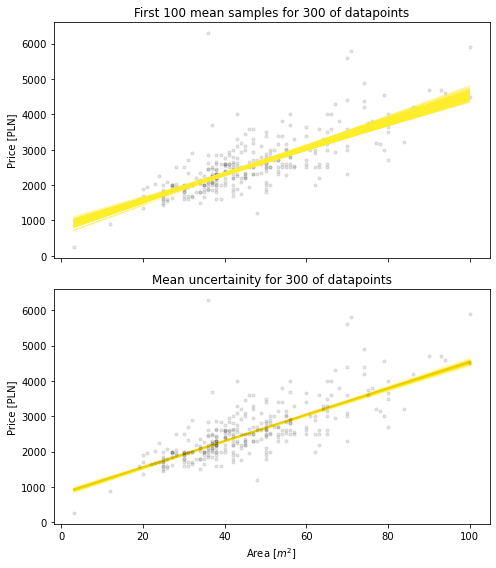

In [180]:
fig, axes = plt.subplots(2,1, figsize=(7, 8),sharey=True,sharex=True)
ax0=axes[0]

for i in range(NUM_OF_SAMPLES):
    ax0.plot(d_short.area,
              alpha_fit_student[i] + beta_fit_student[i] * d_short.c_area,
              color=MID,
              alpha=0.5,linewidth=0.5)

ax0.scatter(d_short.area, d_short.total_price, color='black', alpha=0.1, s=10)
ax0.set_ylabel('Price [PLN]')
ax0.set_title('First {} mean samples for {} of datapoints'.format(NUM_OF_SAMPLES, len(d_short)))

ax1=axes[1]
ax1=ribbon_plot(d_short.area.values, mu_fit_student, ax1, supress_warning=True)
ax1.scatter(d_short.area, d_short.total_price, color='black', alpha=0.1, s=10)
ax1.set_xlabel('Area [$m^2$]')
ax1.set_ylabel('Price [PLN]')

ax1.set_title('Mean uncertainity for {} of datapoints'.format(len(d_short)))
fig.tight_layout()
plt.show()

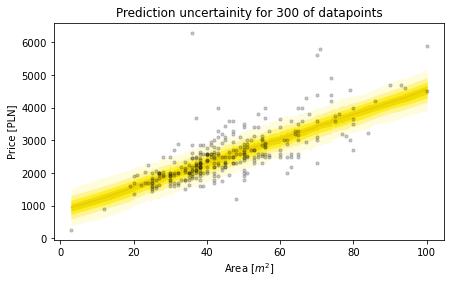

In [181]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes = ribbon_plot(d_short.area.values, price_pred_student, axes, supress_warning=True)
axes.scatter(d_short.area, d_short.total_price,color='black',alpha=0.2,s=10)
axes.set_xlabel('Area [$m^2$]')
axes.set_ylabel('Price [PLN]')
axes.set_title('Prediction uncertainity for {} of datapoints'.format(len(d_short)))
plt.show()

Posterior predictive samples are consistent with observed data. Most of data are in area of interest generated from model. <br>
Area of interest is narrower that in first model, which indicates less uncertainity. In our opinion, that indicates, that model performs better. <br>
There is also strong linear correlation. Model genearates consistent data.

Parameter for slope is sampled sensible, and sampled mean value avarege value of observed data.

Observed data fits very well to area of interest generated from posterior of model. Uncertainity is narrower than in normal distribution [Model 1].

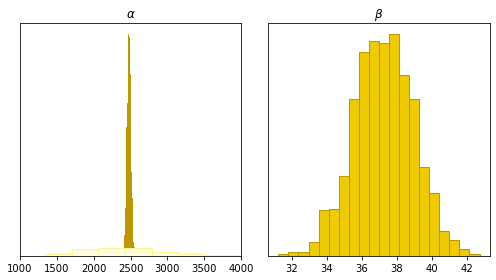

In [182]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

ax = axes[0]
ax.hist(alpha_fit_student, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT, density=True)
ax.hist(data.total_price, bins=20, color=LIGHT, edgecolor=LIGHT_HIGHLIGHT,density=True)
ax.set_title(r'$\alpha$')
ax.set_yticks(())
ax.set_xlim(1000, 4000)

ax2 = axes[1]
ax2.hist(beta_fit_student, bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax2.set_title(r'$\beta$')
ax2.set_yticks(())
fig.tight_layout()
plt.show()


Sampled parameters are cenetered. Sampled alpha has mean value in 2500 and have low standard deviation. <br>
Beta have normal distribution with mean value in 37. <br> 
In plot of alpha is wider range of axis x, than in plot of beta, however parameter beta is also centered. <br>
There is huge improvement of parameters distribution in posterior than in prior predicitve check. <br>
Parameter of beta generally have range that we wanted to achieve by setting prior parameters. <br>

Parameter aplha and beta in student distribution have tighter distribution than in model with normal distribution.

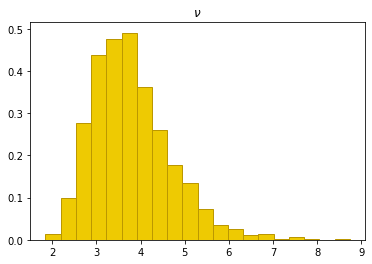

In [183]:
plt.hist(nu_fit_student, bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
plt.title(r'$\nu$')
plt.show()

Distribution of nu is generated from gamma distribution. It means, that student t model has degrees of freedom in range [2, 9]. Gamma is generally diffused. <br>
That values of degrees of freedom ensure, that model student will be different from normal model, as student distribution goes to normal distribution with nu -> inf.

## Marginal for selected area

Generate distribution of price for given area

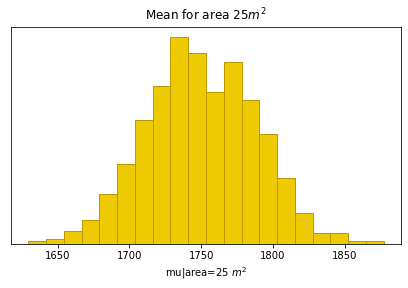

In [184]:
plot_marginal(25, type="student")

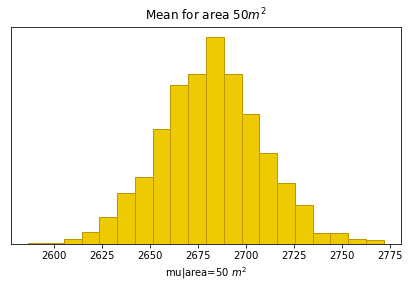

In [185]:
plot_marginal(50, type="student")

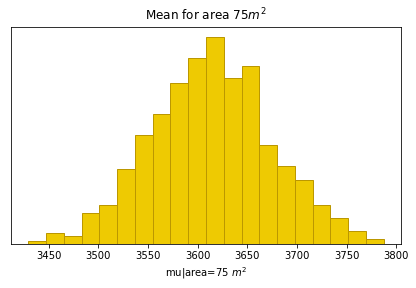

In [186]:
plot_marginal(75, type="student")

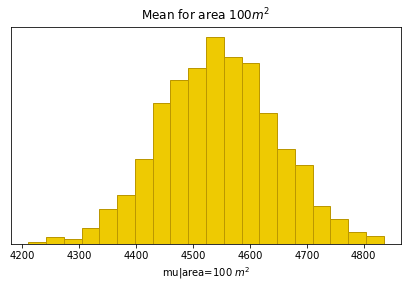

In [187]:
plot_marginal(100, type="student")

# Model comparision

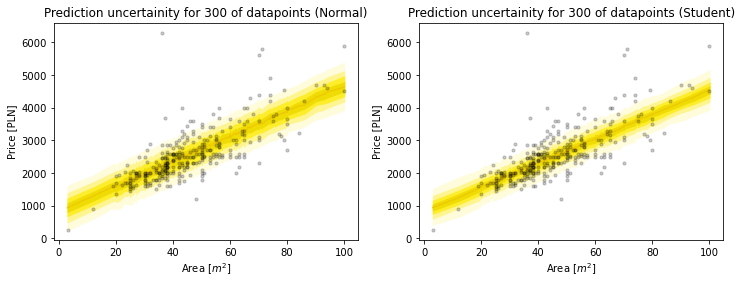

In [188]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax = ribbon_plot(d_short.area.values, price_pred_normal, ax,supress_warning=True)
ax.scatter(d_short.area, d_short.total_price, color='black', alpha=0.2, s=10)
ax.set_xlabel('Area [$m^2$]')
ax.set_ylabel('Price [PLN]')
ax.set_title('Prediction uncertainity for {} of datapoints (Normal)'.format(len(d_short)))

ax1 = axes[1]
ax1 = ribbon_plot(d_short.area.values, price_pred_student, ax1, supress_warning=True)
ax1.scatter(d_short.area, d_short.total_price, color='black', alpha=0.2, s=10)
ax1.set_xlabel('Area [$m^2$]')
ax1.set_ylabel('Price [PLN]')
ax1.set_title('Prediction uncertainity for {} of datapoints (Student)'.format(len(d_short)))

plt.show()

Uncertainity of Student T model is narrower than in Normal model.

In [189]:
az.summary(fit_normal, var_names=['alpha','beta','sigma'], round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,2523.73,29.83,2466.62,2576.11
beta,38.37,1.99,34.55,42.03
sigma,535.27,21.72,492.88,573.54


In [190]:
az.summary(fit_student, var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,2471.22,23.74,2424.07,2511.23
beta,37.26,1.71,34.01,40.38
sigma,348.38,26.34,294.05,392.36


LOO - leave-one-out

In [191]:
arviz_result_normal = az.from_cmdstanpy(posterior=fit_normal)
arviz_result_student = az.from_cmdstanpy(posterior=fit_student)

In [192]:
model_compare_loo = az.compare(dataset_dict ={
    'Normal model':arviz_result_normal, 
    'Student-t model':arviz_result_student
    })

e:\Programy\anconda3\envs\data_env\lib\site-packages\arviz\stats\stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
e:\Programy\anconda3\envs\data_env\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
e:\Programy\anconda3\envs\data_env\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([

In [193]:
model_compare_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Student-t model,0,-2274.223242,4.907528,0.000000,0.920275,18.600772,0.000000,False,log
Normal model,1,-2317.005887,10.073639,42.782645,0.079725,36.244361,25.320937,True,log


Parameters: <br>
rank - indicates which model is better (rank 0 is the best model) - Student-t model performes better than normal model <br>
loo - Information Criterion, higher loo indicates higher out-of-sample predictive fit ("better model") - Studen-t performes better <br>
p_loo - Estimated effective number of parameters <br>
d_loo - Relative difference between each loo <br>
weight - Relative weight for each model (probability of each model given data) <br>
se - Standard error of the IC estimate <br>
dse - Standard error of the difference in IC between each model and the top-ranked model. <br>

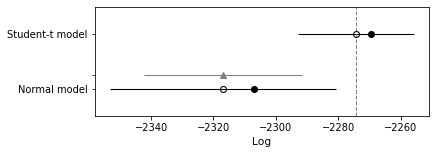

In [194]:
az.plot_compare(model_compare_loo)
plt.show()

Open black dot - value of LOO <br>
Filled black dot - LOO + p_loo <br>
Line size - 2 * SE (Standard Error) <br>
Distance between filled black dots - d_loo <br>
Line with traingle - error of the best model showed for better comparision visualization

Conclusions

Based on LOO model comparison we can see that there is a clear winner, which is student-t model. Models don't overlap on the chart. There was one warning in comparison concerning normal model. It stated that "Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples." and that this is because "importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different"

WAIC - widely applicable information criterion

In [195]:
model_compare_waic = az.compare(dataset_dict ={
    'Normal model':arviz_result_normal, 
    'Student-t model':arviz_result_student
    }, ic="waic")

e:\Programy\anconda3\envs\data_env\lib\site-packages\arviz\stats\stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
e:\Programy\anconda3\envs\data_env\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
e:\Programy\anconda3\envs\data_env\lib\site-packages\arviz\stats\stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
e:\Programy\anconda3\envs\data_env\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The

In [196]:
model_compare_waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Student-t model,0,-2274.176214,4.860499,0.000000,0.920266,18.580418,0.000000,True,log
Normal model,1,-2316.498830,9.566582,42.322616,0.079734,35.795364,24.885564,True,log


Parameters: <br>
rank - indicates which model is better (rank 0 is the best model) - Student-t model performes better than normal model <br>
waic - Information Criterion, higher waic indicates higher out-of-sample predictive fit ("better model") - Studen-t performes better <br>
p_waic - Estimated effective number of parameters <br>
d_waic - Relative difference between each waic <br>
weight - Relative weight for each model (probability of each model given data) <br>
se - Standard error of the IC estimate <br>
dse - Standard error of the difference in IC between each model and the top-ranked model. <br>

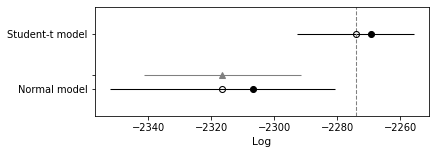

In [197]:
az.plot_compare(model_compare_waic)
plt.show()

Open black dot - value of waic <br>
Filled black dot - waic + p_waic <br>
Line size - 2 * SE (Standard Error) <br>
Distance between filled black dots - d_waic <br>
Line with traingle - error of the best model showed for better comparision visualization


Based on WAIC model comparison we can see that there is a clear winner, which again is student-t model. Models don't overlap on the chart. There was one warning in comparison for both normal and student-t models:

UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4: <br>
Taken from http://arxiv.org/abs/1507.04544 : <br>
"... based on our simulation experiments it seems that estimated effective number of parameters (p_waic) is unreliable if any of the posterior variance of the log predictive density exceeds 0.4." - and this is the case for both models.


## Compare predicted price with observed price

### Normal [Model 1]

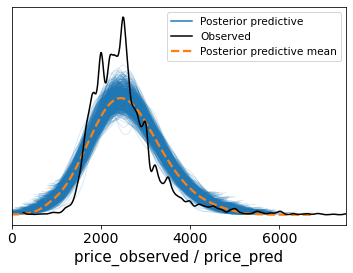

In [198]:
arviz_result_normal = az.from_cmdstanpy(
    posterior=fit_normal,
    posterior_predictive=["price_pred"], 
    observed_data={"price_observed": data['total_price']},
)
arviz_result_normal
az.plot_ppc(arviz_result_normal, data_pairs={"price_observed": "price_pred"})
plt.xlim([0, 7500])
plt.show()

### Student T [Model 2]

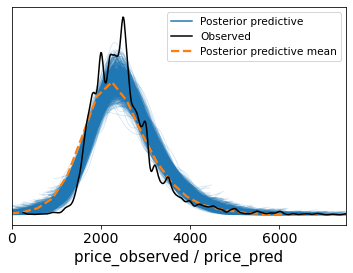

In [199]:
arviz_result_student = az.from_cmdstanpy(
    posterior=fit_student,
    posterior_predictive=["price_pred"], 
    observed_data={"price_observed": data['total_price']},
)
arviz_result_student
az.plot_ppc(arviz_result_student, data_pairs={"price_observed": "price_pred"})
plt.xlim([0, 7500])
plt.show()

## General conclusion

 In our opinion, there is not a big difference between models. However student_t model performs sligtly better. Standard deviation of student model is lower, and parameters are more centered (alpha and beta). Distribution of model 2 prices is closer to observed prices distribution than in case of model 1. All things considered, we agree with result caluclated based on information criteria.